# Overview
- nb005ベースに、パラメータを調節しやすいように書き換えた。
- XGBoostは、二値分類モデル（binary:logistic）を使用。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from common import gini_coefficient

pd.set_option('display.max_columns', 100)

## 1) データ読み込み

In [2]:
# trainデータ
# -----------
data_train = pd.read_csv('../data/train_nb003.csv', index_col=0)
data_train.tail()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_1,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_6,ps_car_01_cat_4,ps_car_01_cat_5,...,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2,target
216935,5,7,0,0,1,0,0,8,0,1,0,0.6,0.4,1.537652,1,0.424264,1.269111,0.384708,3.162278,0.5,0.1,0.5,3,4,9,1,10,2,9,10,1,5,7,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1.897367,0.30,0.06,0.30,0.16,0.615061,0.169706,0.507645,0.153883,1.264911,0.20,0.04,0.20,2.364375,0.652371,1.951452,0.591547,4.862484,0.768826,0.153765,0.768826,0.18,0.538438,0.163218,1.341641,0.212132,0.042426,0.212132,1.610644,0.488237,4.013282,0.634556,0.126911,0.634556,0.1480,1.216553,0.192354,0.038471,0.192354,10.0,1.581139,0.316228,1.581139,0.25,0.05,0.25,0.01,0.05,0.25,1
216936,1,5,0,0,1,0,0,4,0,0,1,0.3,0.4,0.897653,2,0.424264,0.756979,0.400000,2.000000,0.3,0.4,0.6,1,1,8,2,9,5,9,9,2,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.600000,0.09,0.12,0.18,0.16,0.359061,0.169706,0.302791,0.160000,0.800000,0.12,0.16,0.24,0.805782,0.380842,0.679504,0.359061,1.795307,0.269296,0.359061,0.538592,0.18,0.321159,0.169706,0.848528,0.127279,0.169706,0.254558,0.573017,0.302791,1.513957,0.227094,0.302791,0.454187,0.1600,0.800000,0.120000,0.160000,0.240000,4.0,0.600000,0.800000,1.200000,0.09,0.12,0.18,0.16,0.24,0.36,1
216937,0,6,0,1,0,0,0,9,0,1,0,0.9,0.3,0.711952,3,0.400000,0.970654,0.372424,3.464102,0.5,0.4,0.6,2,2,8,2,8,4,10,3,2,1,6,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,3.117691,0.45,0.36,0.54,0.09,0.213585,0.120000,0.291196,0.111727,1.039230,0.15,0.12,0.18,0.506875,0.284781,0.691059,0.265148,2.466272,0.355976,0.284781,0.427171,0.16,0.388262,0.148970,1.385641,0.200000,0.160000,0.240000,0.942169,0.361495,3.362445,0.485327,0.388262,0.582392,0.1387,1.290116,0.186212,0.148970,0.223455,12.0,1.732051,1.385641,2.078461,0.25,0.20,0.30,0.16,0.24,0.36,1
216938,0,2,1,0,0,0,0,2,0,0,1,0.6,0.1,0.577170,2,0.316228,0.876295,0.320780,3.741657,0.5,0.2,0.6,3,0,9,3,10,4,11,5,0,4,4,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,2.244994,0.30,0.12,0.36,0.01,0.057717,0.031623,0.087629,0.032078,0.374166,0.05,0.02,0.06,0.333125,0.182517,0.505771,0.185145,2.159572,0.288585,0.115434,0.346302,0.10,0.277109,0.101440,1.183216,0.158114,0.063246,0.189737,0.767893,0.281098,3.278795,0.438147,0.175259,0.525777,0.1029,1.200250,0.160390,0.064156,0.192468,14.0,1.870829,0.748331,2.244994,0.25,0.10,0.30,0.04,0.12,0.36,1
216939,1,1,0,0,1,0,0,13,1,0,0,0.6,0.4,1.095160,2,0.374166,0.752558,0.328634,3.464102,0.2,0.6,0.3,1,1,8,2,11,0,13,7,2,4,9,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,2.078461,0.12,0.36,0.18,0.16,0.438064,0.149666,0.301023,0.131453,1.385641,0.08,0.24,0.12,1.199375,0.4

In [3]:
# testデータ
# ----------
data_test = pd.read_csv('../data/test_nb003.csv', index_col=0)
data_test.tail()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_1,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_6,ps_car_01_cat_4,ps_car_01_cat_5,...,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
892811,0,6,0,1,0,0,0,2,0,0,1,0.5,0.3,1.048809,2,0.565685,1.528774,0.565685,3.605551,0.3,0.4,0.9,1,1,7,3,10,3,10,4,2,3,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0.282843,1.802776,0.15,0.20,0.45,0.09,0.314643,0.169706,0.458632,0.169706,1.081665,0.09,0.12,0.27,1.100000,0.593296,1.603391,0.593296,3.781534,0.314643,0.419524,0.943928,0.32,0.864805,0.320000,2.039608,0.169706,0.226274,0.509117,2.337149,0.864805,5.512072,0.458632,0.611509,1.375896,0.3200,2.039608,0.169706,0.226274,0.509117,13.0,1.081665,1.442221,3.244996,0.09,0.12,0.27,0.16,0.36,0.81
892812,5,5,0,0,1,0,0,11,1,0,0,0.7,1.0,1.246495,2,0.424264,1.040567,0.418569,3.741657,0.3,0.2,0.6,1,3,7,3,10,4,9,6,2,2,11,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0.292998,2.619160,0.21,0.14,0.42,1.00,1.246495,0.424264,1.040567,0.418569,3.741657,0.30,0.20,0.60,1.553750,0.528843,1.297062,0.521744,4.663958,0.373949,0.249299,0.747897,0.18,0.441475,0.177584,1.587451,0.127279,0.084853,0.254558,1.082780,0.435549,3.893446,0.312170,0.208113,0.624340,0.1752,1.566142,0.125571,0.083714,0.251141,14.0,1.122497,0.748331,2.244994,0.09,0.06,0.18,0.04,0.12,0.36
892813,0,5,1,0,0,0,0,5,0,0,1,0.4,0.0,0.609303,2,0.374166,0.968992,0.390384,3.741657,0.3,0.3,0.9,2,1,10,4,8,2,8,5,2,2,11,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.156154,1.496663,0.12,0.12,0.36,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.371250,0.227980,0.590410,0.237862,2.279803,0.182791,0.182791,0.548373,0.14,0.362564,0.146068,1.400000,0.112250,0.112250,0.336749,0.938946,0.378280,3.625638,0.290698,0.290698,0.872093,0.1524,1.460685,0.117115,0.117115,0.351346,14.0,1.122497,1.122497,3.367492,0.09,0.09,0.27,0.09,0.27,0.81
892814,6,5,0,0,0,1,0,13,1,0,0,0.6,0.6,0.920937,3,0.387298,0.725125,0.378153,2.645751,0.1,0.1,0.3,1,1,9,2,10,1,8,1,1,2,7,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0.226892,1.587451,0.06,0.06,0.18,0.36,0.552562,0.232379,0.435075,0.226892,1.587451,0.06,0.06,0.18,0.848125,0.356677,0.667794,0.348255,2.436570,0.092094,0.092094,0.276281,0.15,0.280840,0.146458,1.024695,0.038730,0.038730,0.116190,0.525806,0.274208,1.918500,0.072512,0.072512,0.217537,0.1430,1.000500,0.037815,0.037815,0.113446,7.0,0.264575,0.264575,0.793725,0.01,0.01,0.03,0.01,0.03,0.09
892815,7,4,0,0,0,1,0,12,1,0,0,0.9,0.8,0.992157,1,0.316228,0.637175,0.296648,3.316625,0.4,0.4,0.2,3,4,7,2,8,4,15,5,2,2,7,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0.266983,2.984962,0.36,0.36,0.18,0.64,0.793725,0.252982,0

In [4]:
# testデータ(id)
# --------------
id_test = pd.read_csv('../data/id_test_nb003.csv', index_col=0)
id_test.tail()

,id
892811,1488022
892812,1488023
892813,1488024
892814,1488025
892815,1488026


In [5]:
X = data_train.drop('target', axis=1)
y = data_train['target']
X_test = data_test

## 2) 解析

In [6]:
# 訓練用、チェック用にデータ分割
# -------------------------------

from sklearn.model_selection import train_test_split

X_train, X_check, y_train, y_check = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)   # 訓練:テスト = 80:20

print('Label counts in y_train: [0 1] =', np.bincount(y_train.astype(np.int64)))
print('Label counts in y_check: [0 1] =', np.bincount(y_check.astype(np.int64)))

Label counts in y_train: [0 1] = [156197  17355]
Label counts in y_check: [0 1] = [39049  4339]


In [40]:
# ===============
# Model: mdl_xgb
# XGBoost / 分類
# ===============

import xgboost as xgb

### データ加工
xgb_train = xgb.DMatrix(X_train.values, label=y_train, feature_names=X.columns)
xgb_check = xgb.DMatrix(X_check.values, label=y_check, feature_names=X.columns)
xgb_test = xgb.DMatrix(X_test.values, feature_names=X.columns)

### モデルパラメータ設定
params = {'objective':'binary:logistic', 'eta':0.01, 'random_state':21}
# "binary:logistic"は、二値分類、ロジスティック回帰の意味
# "eta"はLearning Rateに相当するもの

watchlist=[(xgb_train, 'train'), (xgb_check, 'check')]
evals_result ={}
# "evals_result": 解析過程保存用

### モデル構築
mdl_xgb = xgb.train(params=params, dtrain=xgb_train,
                    num_boost_round=10000, early_stopping_rounds=100,
                    custom_metric=gini_coefficient.gini_xgb, maximize=True,
                    evals=watchlist, evals_result=evals_result, verbose_eval=50
                   )
# 評価指標は"gini_xgb"で、"maximixe=True"で大きいほうがよいと設定

### ベスト時点の結果出力
print('Normalized Gini Coef (Train):', gini_coefficient.gini_xgb(mdl_xgb.predict(xgb_train, ntree_limit=mdl_xgb.best_ntree_limit), xgb_train))
print('Normalized Gini Coef (Check):', gini_coefficient.gini_xgb(mdl_xgb.predict(xgb_check, ntree_limit=mdl_xgb.best_ntree_limit), xgb_check))

[0]	train-logloss:0.68671	train-gini_xgb:0.22348	check-logloss:0.68673	check-gini_xgb:0.20752
[50]	train-logloss:0.47845	train-gini_xgb:0.26560	check-logloss:0.47939	check-gini_xgb:0.23947
[100]	train-logloss:0.38788	train-gini_xgb:0.28038	check-logloss:0.38976	check-gini_xgb:0.24594
[150]	train-logloss:0.34599	train-gini_xgb:0.29418	check-logloss:0.34888	check-gini_xgb:0.25227
[200]	train-logloss:0.32619	train-gini_xgb:0.31059	check-logloss:0.33013	check-gini_xgb:0.26028
[250]	train-logloss:0.31659	train-gini_xgb:0.32679	check-logloss:0.32162	check-gini_xgb:0.26689
[300]	train-logloss:0.31156	train-gini_xgb:0.33992	check-logloss:0.31777	check-gini_xgb:0.27048
[350]	train-logloss:0.30862	train-gini_xgb:0.35058	check-logloss:0.31599	check-gini_xgb:0.27281
[400]	train-logloss:0.30661	train-gini_xgb:0.36060	check-logloss:0.31507	check-gini_xgb:0.27529
[450]	train-logloss:0.30502	train-gini_xgb:0.36984	check-logloss:0.31456	check-gini_xgb:0.27749
[500]	train-logloss:0.30363	train-gini_xgb:

In [113]:
### testデータで予測
xgb_pred = mdl_xgb.predict(xgb_test)
# Classifierだが".predict"で確率を予測出力する

submission_proba = pd.DataFrame({"id": id_test['id'], "target": xgb_pred})
# 書き込みには予測出力の2列目(target=1の確率)を使用する

# csvに出力
#submission_proba.to_csv("submission_nb005_xgb.csv", index = False)

submission_proba

,id,target
0,0,0.080486
1,1,0.066627
2,2,0.079647
3,3,0.041834
4,4,0.108086
...,...,...
892811,1488022,0.256668
892812,1488023,0.119764
892813,1488024,0.101636
892814,1488025,0.066480


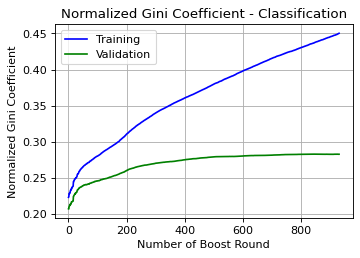

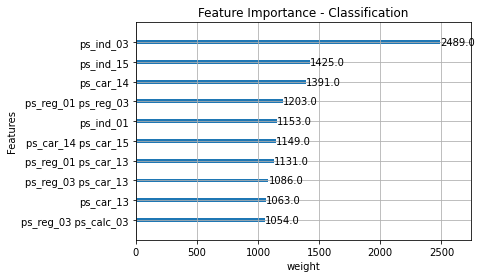

In [41]:
# 結果の可視化
# =============

### 解析過程グラフ出力
fig1 = plt.figure(figsize=(4.8, 3.2), dpi=80)

plt.plot(evals_result['train']['gini_xgb'], color='blue', markersize=5, label='Training')
plt.plot(evals_result['check']['gini_xgb'], color='green', markersize=5, label='Validation')
plt.grid()
plt.title('Normalized Gini Coefficient - Classification')
plt.xlabel('Number of Boost Round')
plt.ylabel('Normalized Gini Coefficient')
plt.legend()

plt.savefig('../image/nb007_norm_gini_cla.png')

### パラメータ重要度出力
xgb.plot_importance(mdl_xgb, importance_type='weight', max_num_features=10,
                    title='Feature Importance - Classification', xlabel='weight', ylabel='Features')

plt.savefig('../image/nb007_feat_importance_cla.png')